# Cole-Cole

There are various different definitions of a cole-cole model, see for instance Tarasov and Titov (2013). We try a few different ones here, but you can supply your preferred version.

The original model is given by Cole and Cole (1941),

$$
\sigma(\omega) = \sigma_\infty + \frac{\sigma_0 - \sigma_\infty}{1 + (i\omega\tau)^C}\ . \qquad\qquad\qquad (1)
$$

Another, similar model is given by Pelton et al. (1978),

$$
\rho(\omega) = \rho_\infty + \frac{\rho_0 - \rho_\infty}{1 + (i\omega\tau)^C}\ . \qquad\qquad\qquad (2)
$$

Equation (2) is just like equation (1), but replaces $\sigma$ by $\rho$. However, mathematically they are not the same. Substituting $\rho = 1/\sigma$ in the latter and resolving it for $\sigma$ will not yield the former. Equation (2) is usually written in the following form, using the chargeability $m = (\rho_0-\rho_\infty)/\rho_0$,

$$
\rho(\omega) = \rho_0 \left[1 - m \left(1- \frac{1}{1 + (i\omega\tau)^C} \right)\right]\ . \quad (3)
$$

In all cases we add the part coming form displacement currents, even tough it doesn't matter in the frequency range of IP.

## WARNING

This is work in progress and might change anytime. **It is not working with the stable release of empymod**. You have to use the branch [cole-cole](https://github.com/empymod/empymod/tree/cole-cole).

### References

**Cole, K.S., and R.H. Cole, 1941**, Dispersion and adsorption in dielectrics. I. Alternating current characteristics; *Journal of Chemical Physics*, Volume 9, Pages 341-351, doi: [10.1063/1.1750906](https://doi.org/10.1063/1.1750906).

**Pelton, W.H., S.H. Ward, P.G. Hallof, W.R. Sill, and P.H. Nelson, 1978**, Mineral discrimination and removal of inductive coupling with multifrequency IP, *Geophysics*, Volume 43, Pages 588-609, doi: [10.1190/1.1440839](https://doi.org/10.1190/1.1440839).

**Tarasov, A., and K. Titov, 2013**, On the use of the Cole–Cole equations in spectral induced polarization; *Geophysical Journal International*, Volume 195, Issue 1, Pages 352-356, doi: [10.1093/gji/ggt251](https://doi.org/10.1093/gji/ggt251).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from empymod import bipole, versions
from empymod.utils import _check_var

In [2]:
# Plot-style adjustments
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 100

## Define the Cole-Cole model

We define our models here which we will feed to `empymod.dipole` or `empymod.bipole`. You have to leave the input signature `func(inp, freq, aniso, etaH, etaV)` and the output signature `return etaH, etaV` unchanged, but everything else you can adjust to your needs; `inp` is the dictionary you provide instead of resistivity `res`.

By default, `etaH`/`etaV` are calculated like this:
    
    etaH = 1/res + 2j*np.pi*freq*epermH*epsilon_0
    etaV = 1/(res*aniso**2) + 2j*np.pi*freq*epermV*epsilon_0

With this function we recalculate it. We replace the real part, the conductivity, by a complex, frequency-dependent conductivity. Then we add back the imaginary part coming from eperm (basically zero for low frequencies).

In [3]:
def cole_cole(inp, freq, aniso, etaH, etaV):
    """Cole and Cole (1941)."""   
    # Get required variables from cond, check them.
    cond_0 = _check_var(inp['cond_0'], float, 1, 'cond_0', aniso.shape)
    cond_8 = _check_var(inp['cond_8'], float, 1, 'cond_8', aniso.shape)
    tau = _check_var(inp['tau'], float, 1, 'tau', aniso.shape)
    c = _check_var(inp['c'], float, 1, 'c', aniso.shape)

    # Calculate complex conductivity from cole-cole
    iomega = 2j*np.pi*freq
    condH = cond_8 + (cond_0-cond_8)/(1 + np.outer(iomega, tau)**c)
    condV = condH/aniso**2

    # Add electric permittivity
    etaH = condH + 1j*etaH.imag
    etaV = condV + 1j*etaV.imag

    return etaH, etaV


def pelton_et_al(inp, freq, aniso, etaH, etaV):
    """ Pelton et al. (1978)."""
    # Get required variables from cond, check them.
    rho_0 = _check_var(inp['rho_0'], float, 1, 'rho_0', aniso.shape)
    m = _check_var(inp['m'], float, 1, 'm', aniso.shape)
    tau = _check_var(inp['tau'], float, 1, 'tau', aniso.shape)
    c = _check_var(inp['c'], float, 1, 'c', aniso.shape)

    # Calculate complex conductivity from cole-cole
    iomega = 2j*np.pi*freq
    rhoH = rho_0*(1 - m*(1 - 1/(1 + np.outer(iomega, tau)**c)))
    rhoV = rhoH*aniso**2

    # Add electric permittivity
    etaH = 1/rhoH + 1j*etaH.imag
    etaV = 1/rhoV + 1j*etaV.imag

    return etaH, etaV

## Example

Two half-space model, air above earth:

- x-directed sourcer at the surface
- x-directed receiver, also at the surface, inline at an offset of 500 m. 
- Switch-on time-domain response
- Isotropic
- Model [air, subsurface]
    - $\rho_\infty = 1/\sigma_\infty =$ [2e14, 10]
    - $\rho_0 = 1/\sigma_0 =$ [2e14, 5]
    - $\tau =$ [0, 1]
    - $c =$ [0, 0.5]

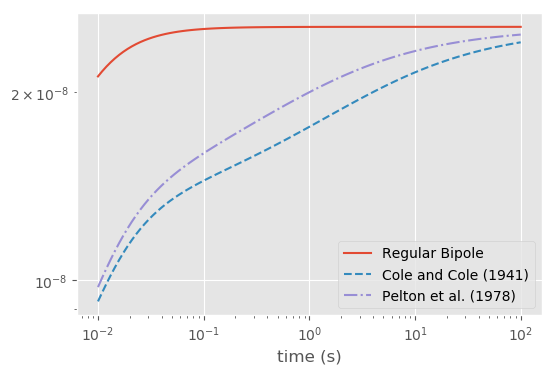

In [4]:
# Times
times = np.logspace(-2, 2, 101)

# Model parameter which apply for all
model = {
    'src': [0, 0, 1e-5, 0, 0],
    'rec': [500, 0, 1e-5, 0, 0],
    'depth': 0,
    'epermH': [0, 1],  # To improve early times in land CSEM
    'epermV': [0, 1],  # (diffusive approximation for airwave)
    'freqtime': times,
    'signal': 1,
    'verb': 1
}

# Collect cole-cole models
res_0 = np.array([2e14, 10])
res_8 = np.array([2e14, 5])
tau = [0, 1]
c = [0, 0.5]
m = (res_0-res_8)/res_0

cole_model = {'res': res_0, 'cond_0': 1/res_0, 'cond_8': 1/res_8,
              'tau': tau, 'c': c, 'func': cole_cole}
pelton_model = {'res': res_0, 'rho_0': res_0, 'm': m, 
                'tau': tau, 'c': c, 'func': pelton_et_al}

# Calculate
out_bipole = bipole(res=res_0, **model)
out_cole = bipole(res=cole_model, **model)
out_pelton = bipole(res=pelton_model, **model)

# Plot
plt.figure()
plt.plot(times, out_bipole, label='Regular Bipole')
plt.plot(times, out_cole, '--', label='Cole and Cole (1941)')
plt.plot(times, out_pelton, '-.', label='Pelton et al. (1978)')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('time (s)')
plt.show()

In [5]:
versions('HTML')